In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
#pd.set_option('display.max_colwidth', 1000)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#"([0-9][^0-9]?[^0-9]?)+[0-9]" # поиск последовательности цифр-букв: "цена договорная. вф8в948фы540ыф80вф07аф"

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, feature_extraction,  preprocessing, metrics
import time
from datetime import datetime # для записи в файл
import re
import string

In [3]:
# Загрузка данных
folder_link = 'C:/Users/Andrei/Python files/ML course Yandex/Хорошие работы/Avito/'
train_df = pd.read_csv(folder_link + 'train.csv')
val_df = pd.read_csv(folder_link + 'val.csv')

In [4]:
pd.options.display.max_colwidth = 100
train_df.head()

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Диван-кровать,Продаем диван-кровать. Удобный механизм - еврокнижка. Размер спального места 640-200. Все подушк...,Мебель и интерьер,Для дома и дачи,7000.0,Россия,Москва,2019-06-01 00:00:15.180656,0
1,Кожух рулевой колонки Даф хф 91 4509834,Кожух рулевой колонки DAF XF 94 (60066004)/\n /\nартикул 2309862/\n /\nВ наличии на складе./\n /...,Запчасти и аксессуары,Транспорт,2290.0,Россия,Москва,2019-06-01 00:00:44.317933,0
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! /\nОтвечу сразу на вопрос: почему здесь?/\n2) Я ли...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа USB для подключения накопителей и специализирован...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
4,Открытка-конверт,Открытки-конверты ручной работы/\nВыполнены в технике скрапбукинг,Коллекционирование,Хобби и отдых,150.0,Ставропольский край,Ессентукская,2019-06-01 00:00:56.632655,0


In [5]:
train_df.shape

(984487, 9)

In [6]:
val_df.shape

(16237, 9)

# Explorational analysis

#### Функция для табличного анализа категорий и подкатегорий

In [7]:
def ctg_sct(df, ctg, sct, topn=0):   
    
    rank_df = pd.DataFrame(columns = [ctg, sct, 'volume_'+ctg,'bad_'+ctg, 'fraction_'+ctg, 'volume_'+sct, 'bad_'+sct,'fraction_'+sct]) 
    ctg_count = df[ctg].value_counts() 
    bad_index = (df.is_bad==1)
    
    for c in ctg_count.index:
        
        sct_count = df.loc[(df[ctg]==c), sct].value_counts()
        bad_records_in_ctg = df.loc[bad_index & (df[ctg]==c)].shape[0]
       
    
        for i,s in enumerate(sct_count.index):
            bad_records_in_sct = df.loc[bad_index & (df[sct]==s)].shape[0]
            record = {
                      ctg : c,
                      sct : s,
                      'volume_'+ctg: ctg_count[c],
                      'bad_'+ctg: bad_records_in_ctg,
                      'fraction_'+ctg: round(bad_records_in_ctg/ctg_count[c],2),
                      'volume_'+sct: sct_count[s],
                      'bad_'+sct: bad_records_in_sct,
                      'fraction_'+sct:  round(bad_records_in_sct/ bad_records_in_ctg,2)                    
                      }
            rank_df = rank_df.append(record, ignore_index=True)
            if i+1 == topn:
                break
    rank_df.sort_values(by=['fraction_category','category','fraction_subcategory'], ascending = False, inplace = True)
    return rank_df   

#### Ключевые category, subcategory для анализа

In [8]:
ctg_sct(val_df, 'category','subcategory',2)[['category','subcategory','fraction_category','fraction_subcategory','bad_subcategory']]

,category,subcategory,fraction_category,fraction_subcategory,bad_subcategory
13,Работа,Резюме,0.50,0.65,176
14,Работа,Вакансии,0.50,0.35,94
17,Животные,Другие животные,0.50,0.54,57
18,Животные,Собаки,0.50,0.14,15
8,Недвижимость,Квартиры,0.48,0.65,545
9,Недвижимость,"Дома, дачи, коттеджи",0.48,0.19,155
12,Услуги,Предложение услуг,0.46,1.00,311
0,Транспорт,Запчасти и аксессуары,0.31,0.63,1073
1,Транспорт,Автомобили,0.31,0.25,422
4,Для дома и дачи,Ремонт и строительство,0.18,0.53,180


#### Функция для визуального анализа

In [9]:
# Функция анализа создает DF: индекс=запись, количество таких записей, доля плохих записей
def df_analysis(df, feature, threshold):   
    records = df[feature].value_counts()    
    rank_df = pd.DataFrame(data = np.zeros((len(records.index),2)), columns = ['Volume', 'Fraction'], index = records.index) 
    for i in rank_df.index:
        rank_df.loc[i, 'Volume'] = records[i]
        rank_df.loc[i, 'Fraction'] = df.loc[(df[feature] == i)&(df.is_bad == 1),feature].shape[0] /records[i]
    #print(rank_df.sort_values(by=['Fraction'],ascending=False))
    return rank_df.loc[rank_df.Fraction>=threshold,:]

# Функция отрисовки и разметки скаттерплота по датафрейму
def draw_sct(ax, df, ttl):  
    ax.set_title(ttl, fontsize=16)
    ax.scatter(df.Volume, df.Fraction)
    for i, txt in enumerate(df.index):
        ax.annotate(txt, (df.Volume[i], df.Fraction[i]), fontsize=10)

# Функция зупуска отрисовки скаттерплота для обучающего и валидационного набора данных
def sct(feature, v_df, t_df, threshold=0):      
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5), sharey = True)
    fig.suptitle(feature +', threshold='+str(threshold) , fontsize=14, fontweight='bold')
    fig.text(0.5, 0.04, 'количество объявлений', ha='center', va='center', fontsize=14)
    fig.text(0.06, 0.5, '% плохих объявлений', ha='center', va='center', rotation='vertical', fontsize=14)  
    draw_sct(ax1, df_analysis(v_df, feature, threshold), 'validation')
    draw_sct(ax2, df_analysis(t_df, feature, threshold), 'train')

# category + subcategory

Т.к. при оценке будет усредняться AUC_ROC по каждой категории, то категории необходимо проанализировать все (и большие, и маленькие).

А вот внутри категории имеет смысл фокусироваться на самых больших подкатегориях, чтобы по ним было максимальное качество!!!

Нужно побить baseline=0.9, так что акцент на валидационные данные!!!

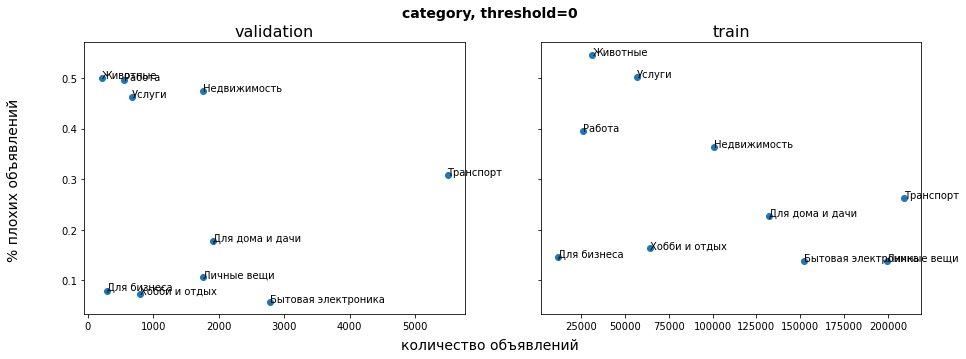

In [10]:
sct('category', val_df, train_df)

#### subcategory для category == 'Животные' 

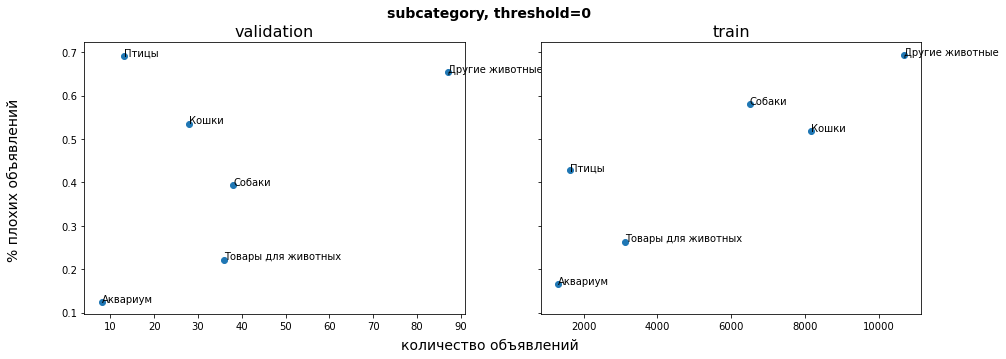

In [11]:
sct('subcategory', val_df.loc[val_df.category == 'Животные',:], train_df.loc[train_df.category == 'Животные',:])

Аналогично можно проанализировать любую подкатегорию

# region + city

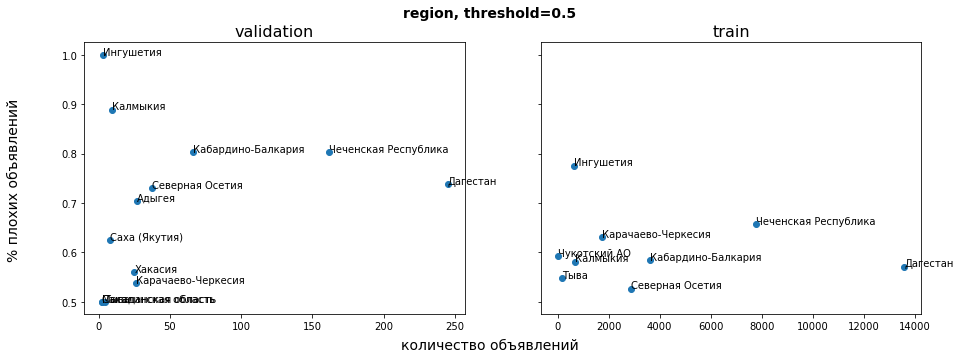

In [12]:
sct('region', val_df, train_df, 0.5)

Регион - очень сильный предиктор

# datetime_submitted

In [13]:
train_df.datetime_submitted = pd.to_datetime(train_df.datetime_submitted)
val_df.datetime_submitted = pd.to_datetime(val_df.datetime_submitted)

In [14]:
train_df['year']=train_df.datetime_submitted.dt.year
val_df['year']=val_df.datetime_submitted.dt.year

In [15]:
train_df['month']=train_df.datetime_submitted.dt.month
val_df['month']=val_df.datetime_submitted.dt.month

In [16]:
train_df['day']=train_df.datetime_submitted.dt.day
val_df['day']=val_df.datetime_submitted.dt.day

In [17]:
train_df['hour']=train_df.datetime_submitted.dt.hour
val_df['hour']=val_df.datetime_submitted.dt.hour

In [18]:
val_df.year.value_counts()

2019    16237
Name: year, dtype: int64

In [19]:
train_df.year.value_counts()

2019    984487
Name: year, dtype: int64

In [20]:
train_df.month.value_counts()

8     238540
9     230465
6     226905
7     216421
10     72156
Name: month, dtype: int64

In [21]:
val_df.month.value_counts()

10    16237
Name: month, dtype: int64

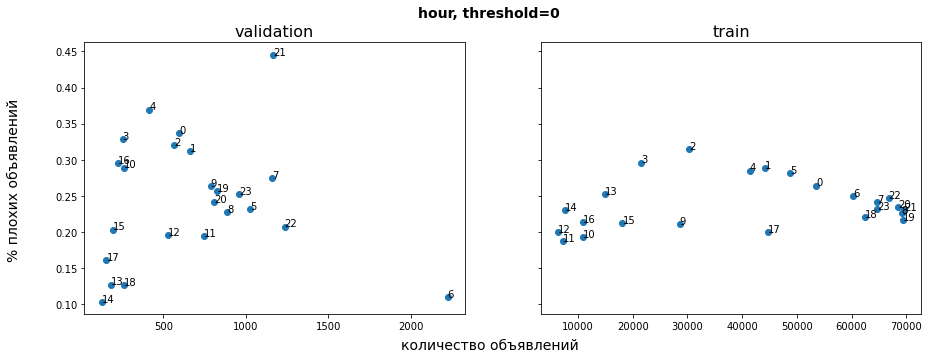

In [22]:
sct('hour', val_df, train_df)

Таким образом: 

Обучающая и валидационная выборка содержит данные только за 2019 год, причем валидация только за 10ый месяц, поэтому оринтироваться на год, месяц не нужно. (День также отбрасываю).
С точки зрения времени размещения видно, что в обучающем датасете данные распределены примерно равномерно (с точки зрения доли плохих объявлений), поэтому время также отрбасываю.

In [23]:
train_df.drop(columns=['datetime_submitted', 'year', 'month', 'day', 'hour'], inplace=True)
val_df.drop(columns=['datetime_submitted', 'year', 'month', 'day', 'hour'], inplace=True)

# price

In [24]:
# посмотрим средние цены в подкатегориях
subcat_price = train_df[['subcategory','price']].groupby(['subcategory']).mean().round() # subcat_price.loc['Автомобили','price'] # Средняя цена по subcategory
subcat_price.sort_values(by=['price'], inplace=True)

In [25]:
def prnt(mn, mx, df):
    
    if mn==1000:
        print('____________________________________________')

    print('СРЕДНЯЯ ЦЕНА [{},{}] т.р.:'.format(mn,mx)) 
    for i in df.index:
        if df.loc[i,'price']>= mn*1000 and df.loc[i,'price']< mx*1000:
            print(' -',i, int(round(df.loc[i,'price']/1000,0)))
    print()

In [26]:
prnt(0, 1, subcat_price)
prnt(1, 10, subcat_price)
prnt(10, 100, subcat_price)
prnt(100, 1000, subcat_price)
prnt(1000, 10000, subcat_price)
prnt(10000, 1000000, subcat_price)

СРЕДНЯЯ ЦЕНА [0,1] т.р.:

СРЕДНЯЯ ЦЕНА [1,10] т.р.:
 - Товары для животных 3
 - Посуда и товары для кухни 4
 - Аквариум 4
 - Товары для компьютера 6
 - Планшеты и электронные книги 8
 - Оргтехника и расходники 8
 - Игры, приставки и программы 8
 - Билеты и путешествия 10

СРЕДНЯЯ ЦЕНА [10,100] т.р.:
 - Спорт и отдых 12
 - Велосипеды 12
 - Фототехника 13
 - Аудио и видео 14
 - Охота и рыбалка 22
 - Музыкальные инструменты 26
 - Ноутбуки 27
 - Бытовая техника 32
 - Настольные компьютеры 39
 - Вакансии 40
 - Часы и украшения 43

СРЕДНЯЯ ЦЕНА [100,1000] т.р.:
 - Мотоциклы и мототехника 120
 - Товары для детей и игрушки 234
 - Ремонт и строительство 235
 - Оборудование для бизнеса 250
 - Комнаты 577
 - Водный транспорт 724

____________________________________________
СРЕДНЯЯ ЦЕНА [1000,10000] т.р.:
 - Книги и журналы 1007
 - Одежда, обувь, аксессуары 1157
 - Телефоны 1472
 - Детская одежда и обувь 1589
 - Запчасти и аксессуары 1664
 - Автомобили 2514
 - Гаражи и машиноместа 3038
 - Квартир

Вызывают удивление большинство значений более 10 млн. руб

In [27]:
# Посмотрим на примере резюме:
df_resume = train_df.loc[(train_df.subcategory=='Птицы') & (train_df.price >= 1000000),:]
for i in df_resume.index:
    print('ЗАГОЛОВОК',df_resume.loc[i, 'title'])
    print('ОПИСАНИЕ',df_resume.loc[i, 'description'])
    print('ЦЕНА', df_resume.loc[i, 'price'])
    print('IS_BAD:',df_resume.loc[i, 'is_bad'])
    print()

ЗАГОЛОВОК Куры 9 шт, Петух 4 шт
ОПИСАНИЕ Продаются куры, семья 9 шт, плюс петух. возраст 5 год (всем). Несут яйца каждый день, то 7 до 9. 100 рублей штука, и петух 5000,Продаю Связи по окончанию дачного сезона. Рубить жалко потому что несутся отлично. Адрес: Ленинградская область, платформа 47 километр Приозерское-Сосновское направление, 89 471 520 309/
Игорь
ЦЕНА 89675120409.0
IS_BAD: 1

ЗАГОЛОВОК Продаются куры,все вопросы по номеру
ОПИСАНИЕ Продажа Кур
ЦЕНА 89280871357.0
IS_BAD: 1



(1) В цену часто вбивают номер телефона (2) Объявления с неадекватной суммой обычно также содержат контактную информацию.
<br>Таким образом, price можно использовать как предиктор

# Подготвка данных

In [28]:
# Функция для вывода на экран ключевых полей объявлений, заданных через индекс
def print_examples(index, df):
    for i in index:
        print('ID', i)
        print('ЗАГОЛОВОК',df.loc[i, 'title'])
        print('ОПИСАНИЕ',df.loc[i, 'description'])
        print('ЦЕНА', df.loc[i, 'price'])
        print('IS_BAD:',df.loc[i, 'is_bad'])
        print()

In [29]:
def parsing(pref, patterns, post, x):
    for p in patterns:
        res = re.findall(pref+p+post, x)
        if res!=[]:
        #if len(res)==1:
            return 1             
    return 0 

In [30]:
def print_fraction(column, df):
    print('Обнаружил по каналу:', df.loc[df[column]!=0].shape[0])
    print('Из них плохими отмечено:',round(val_df.loc[(df[column]!=0)&(df.is_bad==1)].shape[0]/df.loc[df[column]!=0].shape[0],2),'%')

In [31]:
# Замена NaN на 0
train_df.price.fillna(0, inplace = True)
val_df.price.fillna(0, inplace = True)

In [32]:
# Нижний регистр и замена переносов на новую строку
val_df['description']=val_df['description'].apply(lambda x: x.lower())
val_df['description']=val_df['description'].apply(lambda x: x.replace('\n', ' '))
train_df['description']=train_df['description'].apply(lambda x: x.lower()) # train_df.description = train_df.description.str.lower()
train_df['description']=train_df['description'].apply(lambda x: x.replace('\n', ' '))


# Канал №1: телефон и месенджеры

### Коды операторов

In [33]:
total_time = list()

In [34]:
# Отдельная функция, поскольку делаю доп. очистку от знаков пунктуации
def mob_code(x):
    x = x.translate(str.maketrans('', '', string.punctuation)) #очистка от всех знаков пунктуации 
    pref = r'[ 78]'
    patterns = ['9[0-9][0-9]'] # таблица кодов операторов доступна по ссылке: https://codificator.ru/code/mobile/ , однако в объявлениях встречаются примеры с отсутсвующими в таблице кодами, поэтому буду использовать 9XX
    post = ''
    for p in patterns:
        res = re.findall(pref+p+post, x)
        if res!=[]:
            return 1          
    return 0

val_df['mob_code']=val_df['description'].apply(lambda x: mob_code(x))

start_time = time.time()
train_df['mob_code']=train_df['description'].apply(lambda x: mob_code(x))
total_time.append(['mob_code', time.time() - start_time])
print(total_time[-1][1])

68.45552825927734


In [35]:
print_fraction('mob_code', val_df)

Обнаружил по каналу: 5747
Из них плохими отмечено: 0.39 %


### Поиск последовательностей длиной 8-11 цифр

<br>татьяна +79244648575
<br>проживания!/ 89о93999oo8
<br>чр./ 8к9о5д9и8и9и2и0а1а1и0
<br>пишите сюда или what's up, viber по: н+7 о9м4е5р0у423404
<br>в личном хозяйстве. 8и9и4и0и8и1и5и7и6и9и2

In [36]:
def digits_seq8_11(х):    
    pattern = "...9..........?.?.?.?.?.?.?.?.?.?.?.?" # ищем ДЕВЯТКУ и её окресность: 3 символа перед, 9*2 символов после (чтобы ловить такие варианты: 8и9и4и0и8и1и5и7и6и9и2) + 3 символа про запас
    for seq in re.findall(pattern, х):
        digits = re.findall('[0-9]', seq) # вытаскиваем все цифры из найденной комбинации
        number = ''.join(digits)
        ln_number = len(number) # Определили длину последовательности
        first_symbol = re.findall('^[789]', number) # Проверка, что первый символ 7, 8 или 9
        if (first_symbol!=[]) and (8<=ln_number) and (ln_number<=11): # 8,потому что бывают такие примеры: проживания!/ 89о93999oo8
            return 1
    return 0
        
val_df['digits_seq8_11']=val_df['description'].apply(lambda x: digits_seq8_11(x))

start_time = time.time()
train_df['digits_seq8_11']=train_df['description'].apply(lambda x: digits_seq8_11(x))
total_time.append(['digits_seq8_11', time.time() - start_time])
print(total_time[-1][1])

21.255594968795776


### Поиск последовательностей длиной 6-7 цифр

<br>по вопросам 936891
<br>ипотека и т. д. тел. 688181
<br>дополнительный номер: 4-800-323
<br>телефон 22-18-22. на

In [37]:
def digits_seq6_7(x):    
    x = x.translate(str.maketrans('', '', string.punctuation)) #очистка от всех знаков пунктуации 
    pattern = '[0-9][0-9][0-9][0-9][0-9][0-9][0-9]?'
    if re.findall(pattern, x)!=[]:
        return 1          
    else:
        return 0

val_df['digits_seq6_7']=val_df['description'].apply(lambda x: digits_seq6_7(x))

start_time = time.time()
train_df['digits_seq6_7']=train_df['description'].apply(lambda x: digits_seq6_7(x))
total_time.append(['digits_seq6_7', time.time() - start_time])
print(total_time[-1][1])   

68.6838321685791


### Цифры и числа, написанные буквенно

90четыре12восемь,ноль87ноль
<br>восем три семерки четыреста  семьдесят   семь двадцать  четыре  двадцать  семь (вотсап, вайбер)
<br>восемь девятсот двадцать восемь тристо шесдисят девять шестнадцать семьдесят один
<br>Все вопросы по телефону плюссемь931шестьнольдевять06двадцатьодин, звонить до 60.00ч
<br>Ирина. звонить сюда, 9три7968902шесть

In [38]:
# Отдельная функция, поскольку прерываюсь не сразу, а только если обнаружил 2 и более числа/цифры
def numbers_abc_count(x):
    pref = r''
    numbers = ['ноль',	'один',	'два',	'три',	'четыре',	'пять',	'шесть',	'семь',	'восемь',	'девять',	'десять',	'одиннадцать',	'двенадцать',	'тринадцать',	'четырнадцать',	'пятнадцать',	'шестнадцать',	'семнадцать',	'восемнадцать',	'девятнадцать',	'двадцать',	'тридцать',	'сорок',	'пятьдесят',	'шестьдесят',	'семьдесят',	'восемьдесят',	'девяносто',	'сто',	'двести',	'триста',	'четыреста',	'пятьсот',	'шестьсот',	'семьсот',	'восемьсот',	'девятьсот']
    post = ''
    numbers_lst = []
    for p in numbers:
        res = re.findall(pref+p+post, x)
        if res!=[]:
            numbers_lst.append(res)
    return len(numbers_lst)


val_df['numbers_abc_count']=val_df['description'].apply(lambda x: numbers_abc_count(x))

start_time = time.time()
train_df['numbers_abc_count']=train_df['description'].apply(lambda x: numbers_abc_count(x))
total_time.append(['numbers_abc', time.time() - start_time])
print(total_time[-1][1])

74.91012644767761


In [39]:
print_fraction('numbers_abc_count', val_df)

Обнаружил по каналу: 10297
Из них плохими отмечено: 0.22 %


### Подсчёт количества цифр в объявлении

<br>телефон: 8ш9а3ш8ш0ш6ш9ш0ш1ш5ш8
<br>трёхкомнатная 89 квартира 05 для 537 русской 44 семьи,92 цокольный этаж
<br>проживания!/ 89о93999oo8
<br>машина 8п9р5о8д7а3е7т2с6а2в1то званите 
<br>9 !!!8..8 6ттт2ммм5мм 6,,6 @@@9c6

In [40]:
# Отдельная функция, поскольку считаю все цифры и не прерываюсь
def digits_count(x):
    pref = r''
    p = "[0-9]"
    post = ''
    digits_count = len(re.findall(pref+p+post, x))
    return digits_count

val_df['digits_count']=val_df['description'].apply(lambda x: digits_count(x))

start_time = time.time()
train_df['digits_count']=train_df['description'].apply(lambda x: digits_count(x))
total_time.append(['digits_count', time.time() - start_time])
print(total_time[-1][1])

12.934710264205933


In [41]:
print_fraction('digits_count', val_df)

Обнаружил по каналу: 15603
Из них плохими отмечено: 0.24 %


### Подсчёт количества тире

<br>график сменный .оплата 20/20./ 509-03-60
<br>подведено электричество, дом.т: 44-22-6.
<br>на hyundai santafe 2012+. телефон 22-18-22. на 
<br>santafe 1031+. телефон 11- для -38-связи-11. на фото 
<br>(464) 148-50-00
<br>тел. 77-02-67


In [42]:
# Отдельная функция, поскольку считаю все разделители и не прерываюсь
def dash_count(x):
    pref = r''
    p = "[0-9]-[0-9]"
    post = ''   
    return len(re.findall(pref+p+post, x))

val_df['dash_count']=val_df['description'].apply(lambda x: dash_count(x))

start_time = time.time()
train_df['dash_count']=train_df['description'].apply(lambda x: dash_count(x))
total_time.append(['dash_count', time.time() - start_time])
print(total_time[-1][1])

7.490172386169434


In [43]:
print_fraction('dash_count', val_df)

Обнаружил по каналу: 4920
Из них плохими отмечено: 0.24 %


###  Стоп-слова "... по телефону ..."

In [44]:
pref = r''
patterns = ["[ \.,!]т[\.:][^\w]", "[ \.,!]тел[\.:]", "по номеру", "по телефону", "номер телефона", "телефон:"]
post = ''
val_df['stop_w_tel']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_tel']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_tel', time.time() - start_time])
print(total_time[-1][1])

22.985827922821045


In [45]:
print_fraction('stop_w_tel', val_df)

Обнаружил по каналу: 2464
Из них плохими отмечено: 0.53 %


###  Стоп-слова "... звони ..."

In [46]:
pref = r''
patterns = ['звони']
post = ''
val_df['stop_w_zvonit']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_zvonit']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_zvonit', time.time() - start_time])
print(total_time[-1][1])

3.083704948425293


In [47]:
print_fraction('stop_w_zvonit', val_df)

Обнаружил по каналу: 4366
Из них плохими отмечено: 0.29 %


### Стоп-слова "...whatsapp..."

In [48]:
pref = r''
patterns = ['whatsapp', 'вотс ап', 'ватцап']
post = ''
val_df['stop_w_wapp']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_wapp']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_wapp', time.time() - start_time])
print(total_time[-1][1])

6.655667781829834


In [49]:
print_fraction('stop_w_wapp', val_df)

Обнаружил по каналу: 587
Из них плохими отмечено: 0.2 %


### Стоп-слова "...viber..."

In [50]:
pref = r''
patterns = ['viber', 'вайбер', 'вибер']
post = ''
val_df['stop_w_viber']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_viber']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_viber', time.time() - start_time])
print(total_time[-1][1])

6.552030086517334


In [51]:
print_fraction('stop_w_viber', val_df)

Обнаружил по каналу: 555
Из них плохими отмечено: 0.17 %


### Стоп-слова "...телеграм..."

In [52]:
pref = r''
patterns = ["телеграм", "telegram"] 
post = ''
val_df['stop_w_telegram']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_telegram']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_telegram', time.time() - start_time])
print(total_time[-1][1])

4.739315986633301


In [53]:
print_fraction('stop_w_telegram', val_df)

Обнаружил по каналу: 175
Из них плохими отмечено: 0.15 %


### Стоп-слова "...'⃣'..."

In [54]:
pref = r''
patterns = ['⃣'] #с помощью такого символа красиво оформляют номера телефонов
post = ''
val_df['stop_w_square']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_square']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_square', time.time() - start_time])
print(total_time[-1][1])

2.8443753719329834


In [55]:
print_fraction('stop_w_square', val_df)

Обнаружил по каналу: 33
Из них плохими отмечено: 0.39 %


# Канал №2: Ссылки на сайты

### web link 

In [56]:
pref = r''
patterns = [
            "[ \w\(]точка[ ]?ру",
            "[ \.]ru(?:[ \.,!]|$)",
            "http",
            "[ \.]com(?:[ \.,!]|$)",
            "[ \.]by(?:[ \.,!]|$)",
            "[ a-z]точка"
           ]
post = ''
val_df['web_link']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['web_link']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['web_link', time.time() - start_time])
print(total_time[-1][1])

58.411001682281494


In [57]:
print_fraction('web_link', val_df)

Обнаружил по каналу: 355
Из них плохими отмечено: 0.51 %


### Стоп-слова "...ссылка..."

In [58]:
pref = r''
patterns = ["ссылк",
            "сайт"]
post = ''
val_df['stop_w_site']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_site']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_site', time.time() - start_time])
print(total_time[-1][1])

5.197988271713257


In [59]:
print_fraction('stop_w_site', val_df)

Обнаружил по каналу: 2076
Из них плохими отмечено: 0.08 %


### Подсчёт количества букв на английском

In [60]:
# Отдельная функция, поскольку не прерываюсь, а считаю
def letters_count(x):
    pref = r''
    p = '[a-z]'
    post = ''
    return len(re.findall(pref+p+post, x))


val_df['letters_count']=val_df['description'].apply(lambda x: letters_count(x))

start_time = time.time()
train_df['letters_count']=train_df['description'].apply(lambda x: letters_count(x))
total_time.append(['letters_count', time.time() - start_time])
print(total_time[-1][1])

11.257694244384766


# Канал №3: instagram

In [61]:
pref = r''
patterns = ["inst:", 
            "insta:", 
            "instagram:", 
            "instagram.com/", 
            "inst.?.?.?.?.?.?.?.?.?@", #Instagram - @alyonka__chocolate
            "instagram[^,].?.?.?.?.?.?.?.?.?.?.?[a-z]", #Instagram в профиле egorushkina__ # кроме Instagram, YouTube, Facebook...
            "инстаграм[^,].?.?.?.?.?[a-z]", #инстаграм: @broken_avto, инстаграм agsspbsto, инстаграмм: silk_way_tour
            "инста[^,].?.?[a-z]"] # инста @box_me, инста: stas_stupnickiy
post = ''
val_df['inst']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['inst']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['inst', time.time() - start_time])
print(total_time[-1][1])

15.864763975143433


In [62]:
print_fraction('inst', val_df)

Обнаружил по каналу: 171
Из них плохими отмечено: 0.4 %


In [63]:
print('Если посмотреть внимательнее, то все объявления с inst=1 содержат контактную информацию:')
print_examples(val_df.loc[(val_df.inst==1)&(val_df.is_bad==0)].index,val_df)

Если посмотреть внимательнее, то все объявления с inst=1 содержат контактную информацию:
ID 603
ЗАГОЛОВОК Клапан электромагнитный грм (Nissan Qashqai)
ОПИСАНИЕ [арт. 210497] клапан электромагнитный грм/  номер производителя: 217951jv0a/ / подходит на nissan qashqai ii (ниссан, кашкай, j66, 2 )/ /  выкуп авто в любом состоянии./ /  ・・・/ /  артикул 210497. пожалуйста, назовите его при звонке./  объявление висит - запчасть точно в наличии на собственном складе./  весь ассортимент запчастей можно посмотреть, набрав в яндексе или гугле "авторазборка фаворит"./  наш инстаграм: @broken_avto/  если цена кажется вам слишком высокой, звоните - договоримся!/  доставка транспортными компаниями в любую точку россии, украины, белоруссии и казахстана./  гарантия./ / код: 8wekw4e7hpb7amg1mphi9h/ /  клапан электромагнитный грм.
ЦЕНА 3499.0
IS_BAD: 0

ID 604
ЗАГОЛОВОК Клемма аккумулятора плюсовая
ОПИСАНИЕ [арт. 554424-1] клемма аккумулятора плюсовая/  номер производителя: 21159517061/ / подходит на:/  b

#### Все эти объявления на самом деле должны быть с меткой is_bad=1. 
Необходимо переразметить данные на основании полученных признаков inst_eng=1, inst_rus=1 - они являются более достоверными.

# Канал №4 Электронная почта

### Почтовые домены

In [64]:
pref = r'@[ ]?'
patterns = ["mail",
            "yandex",
            "gmail",
            "inbox",
            "yahoo"]
post = ''
val_df['mail']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['mail']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['mail', time.time() - start_time])
print(total_time[-1][1])

11.453498601913452


In [65]:
print_fraction('mail', val_df)

Обнаружил по каналу: 20
Из них плохими отмечено: 0.95 %


### Стоп-слова "...почта..."

In [66]:
pref = r''
patterns = ["почт",
            "пишите"]
post = ''
val_df['stop_w_mail']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_mail']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_mail', time.time() - start_time])
print(total_time[-1][1])

5.0910844802856445


In [67]:
print_fraction('stop_w_mail', val_df)

Обнаружил по каналу: 1886
Из них плохими отмечено: 0.18 %


# Канал №5 vk

In [68]:
pref = r''
patterns = ["[^a-z]vk[^a-z]", "в[ ]?контакт", " вк[ \.,!]"]
post = ''
val_df['stop_w_vk']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_vk']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_vk', time.time() - start_time])
print(total_time[-1][1])

27.80680203437805


In [69]:
print_fraction('stop_w_vk', val_df)

Обнаружил по каналу: 237
Из них плохими отмечено: 0.21 %


# Канал №6 городской адрес

In [70]:
pref = r''
patterns = ["адрес"]
post = ''
val_df['stop_w_adres']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_adres']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_adres', time.time() - start_time])
print(total_time[-1][1])

3.5223231315612793


In [71]:
print_fraction('stop_w_adres', val_df)

Обнаружил по каналу: 1037
Из них плохими отмечено: 0.1 %


# Канал №7 различные спец. символы: _ # ☎ @ 

### Стоп символ _

In [72]:
pref = r''
patterns = ["[a-z]_[a-z]"]
post = ''
val_df['stop_sign__']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

print_fraction('stop_sign__', val_df)

start_time = time.time()
train_df['stop_sign__']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_sign__', time.time() - start_time])
print(total_time[-1][1])

Обнаружил по каналу: 200
Из них плохими отмечено: 0.32 %
8.307492971420288


### Стоп символ 

In [73]:
pref = r''
patterns = ["#"]
post = ''
val_df['stop_sign_#']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

print_fraction('stop_sign_#', val_df)

start_time = time.time()
train_df['stop_sign_#']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_sign_#', time.time() - start_time])
print(total_time[-1][1])

Обнаружил по каналу: 301
Из них плохими отмечено: 0.1 %
3.128089427947998


### Стоп символ ☎

In [74]:
pref = r''
patterns = ["☎"]
post = ''
val_df['stop_sign_tel']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

print_fraction('stop_sign_tel', val_df)

start_time = time.time()
train_df['stop_sign_tel']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_sign_tel', time.time() - start_time])
print(total_time[-1][1])

Обнаружил по каналу: 390
Из них плохими отмечено: 0.05 %
3.1712582111358643


### Стоп символ @

In [75]:
pref = r''
patterns = ["@"]
post = ''
val_df['stop_sign_dog']=val_df['description'].apply(lambda x: parsing(pref, patterns, post, x))

print_fraction('stop_sign_dog', val_df)

start_time = time.time()
train_df['stop_sign_dog']=train_df['description'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_sign_dog', time.time() - start_time])
print(total_time[-1][1])

Обнаружил по каналу: 200
Из них плохими отмечено: 0.45 %
3.4434139728546143


### Размер объявления

In [76]:
val_df['message_size']=val_df['description'].apply(lambda x: len(x))
train_df['message_size']=train_df['description'].apply(lambda x: len(x))

# Применение части функций к заголовку

In [77]:
val_df['mob_code_title']=val_df['title'].apply(lambda x: mob_code(x))

start_time = time.time()
train_df['mob_code_title']=train_df['title'].apply(lambda x: mob_code(x))
total_time.append(['mob_code_title', time.time() - start_time])
print(total_time[-1][1])

10.380169868469238


In [78]:
val_df['numbers_abc_count_title']=val_df['title'].apply(lambda x: numbers_abc_count(x))

start_time = time.time()
train_df['numbers_abc_count_title']=train_df['title'].apply(lambda x: numbers_abc_count(x))
total_time.append(['numbers_abc_count_title', time.time() - start_time])
print(total_time[-1][1])

52.87624549865723


In [79]:
pref = r''
patterns = ["[ \.]т[\.:][^\w]", "[ \.]тел[\.:]", "по номеру", "по телефону", "номер телефона", "телефон:"]
post = ''
val_df['stop_w_tel_title']=val_df['title'].apply(lambda x: parsing(pref, patterns, post, x))

start_time = time.time()
train_df['stop_w_tel_title']=train_df['title'].apply(lambda x: parsing(pref, patterns, post, x))
total_time.append(['stop_w_tel_title', time.time() - start_time])
print(total_time[-1][1])

10.992121696472168


# Подготвка данных для модели

#### Преобразование категориальных признаков

In [80]:
all_columns = train_df.columns.to_list()
real_columns = ['price'] + all_columns[all_columns.index('is_bad')+1:]  # все колонки следующие за IS_BAD
#cat_columns = ['category', 'subcategory', 'region' ,'city']

In [81]:
Yval_df = val_df[['is_bad']]
Y_df = train_df[['is_bad']]


# Для LightGBM необходимо заменить кириллицу на 

# One hot кодирование (все данные не помещаются в RAM, поэтому без 'city')
# Некоторые регионы отсутствуют в валидационных примерах.
# Поэтому, чтобы Xval_df, X_df после one-hot кодирования имели одинаковую структуру колонок - предварительно их объединяю
Union_df = pd.concat([val_df, train_df], ignore_index=True)
Union_df = pd.get_dummies(Union_df[real_columns+['category', 'subcategory', 'region']], prefix=['cat_','subcat_', 'reg_']) #'city_'



Xval_index = val_df.index.to_list() # индексы валидационных примеров
X_index = Union_df.index.to_list()[Xval_index[-1]+1:] # индексы обучающих примеров
Xval_df = Union_df.loc[Xval_index,:] 
X_df = Union_df.loc[X_index,:]
X_df.index=Y_df.index #Взял исходные индексы

#### Масштабирование признаков

In [82]:
scaler_columns = ['price','numbers_abc_count','numbers_abc_count_title','digits_count','dash_count','letters_count','message_size']

scaler = preprocessing.StandardScaler()
scaler.fit(X_df[scaler_columns])
X_df[scaler_columns] = scaler.transform(X_df[scaler_columns])
Xval_df[scaler_columns] = scaler.transform(Xval_df[scaler_columns])

#### Разбиение на обучение и тест

Создадим отдельный признак subcategory + is_bad, который позволит корректно разбить данные на обучение и тест.

In [83]:
#Strat = pd.DataFrame()
#Strat['subcat_is_bad'] = val_df['subcategory'].apply(lambda x: str(x)) + val_df['is_bad'].apply(lambda x: '_' + str(x))
#(X_train, X_test, Y_train, Y_test) = model_selection.train_test_split(X_df, Y_df, stratify=Strat.subcat_is_bad, test_size = 0.3)

# Создание собственной метрики оценки

Среднее арифметическое от AUC_ROC по каждой категории

In [84]:
# зафиксируем номера колонок, в которых содержатся категории после one hot кодирования:
columns = X_df.columns.to_list()
cat_col_name = list()
cat_col_num = list()
for i,c in enumerate(columns):
    if c[0:3]=='cat':
        cat_col_name.append(c)
        cat_col_num.append(i)

In [85]:
# ДАННАЯ ФУНКЦИЯ ИСПОЛЬЗУЕТСЯ ТОЛЬКО В GridsearchCV
# Среднее арифметическое от AUC_ROC по каждой категории
from sklearn.metrics import roc_auc_score
def auc_roc_custom(clf, X, Y): 
    global cat_col_name
    score = list()
    for col_name in cat_col_name:
        X_cat = X.loc[X[col_name]==1,:]
        Y_cat = Y[X[col_name]==1] # Почему-то для y нужен одномерный вектор...
        Y_pred_proba = clf.predict_proba(X_cat)
        score.append(roc_auc_score(Y_cat,Y_pred_proba[:,1]))
    return np.mean(score)

In [86]:
# Функция для записи результатов в файл
def save_result(modelname, opt, X, Y):
    from datetime import datetime       
    # Записываю результаты в файл
    with open('class_task_result.txt', 'a') as ouf:
        ouf.write(datetime.now().strftime("%d/%m/%Y %H:%M:%S") +'\n')
        ouf.write('TRAIN ROC_AUC_average = '+ str(round(opt.best_score_,2))+'\n')
        ouf.write('Модель - ' + modelname + '\n')
        ouf.write('Параметры ='+ str(opt.best_params_)+'\n')
        score = print_score_category_coded(optimizer.best_estimator_, X, Y, prnt=False)
        ouf.write('%-20s %10s %10s\n' % ('CATEGORY', 'ROC_AUC', 'BAD %'))
        ouf.write('______________________________________________\n')
        for i in score:
            ouf.write('%-20s %10s %10s\n' % (i[0],i[1],i[2])) 
        ouf.write(modelname + ' ROC_AUC_average = '+ str(round(np.mean([i[1] for i in score]),2))+'\n')
        ouf.write('\n')      
        
        try:            
            # Список колонок и коэффициенты (искользую переменную real_columns, в которой хранятся колонки с real, они первые)
            valuable_features = list()
            for i, column in enumerate(real_columns):        
                w = optimizer.best_estimator_.coef_[0][i]
                valuable_features.append([column, round(w,3)])                 
            ouf.write('%-20s %10s\n' % ('FEATURE', 'WEIGHT'))
            ouf.write('______________________________________________\n')          
            for i in valuable_features:
                ouf.write('%-20s %10s\n' % (i[0],i[1]))
        except:
            pass
        
        ouf.write('\n')
    print('Результаты записаны в файл class_task_result.txt')

In [96]:
# Функция вывода на экран roc_auc по каждой категории, когда категориальные данные были one hot кодированы
def print_score_category_coded(clf, X, Y, prnt=True):
    from tabulate import tabulate
    global cat_col_name
    score = list()
    for col_name in cat_col_name:
        X_cat = X.loc[X[col_name]==1,:]
        Y_cat = Y.loc[X[col_name]==1,:]
        Y_pred_proba = clf.predict_proba(X_cat)
        bad_fraction = sum(Y_cat.is_bad==1)/Y_cat.shape[0]
        score.append([col_name[5:], round(roc_auc_score(Y_cat,Y_pred_proba[:,1]),2), round(bad_fraction,2)])
    score = sorted(score, key = lambda x: x[1])
    if prnt==True:
        print(tabulate(score, headers=['Category', 'ROC_AUC', 'BAD %']))
        print('ROC_AUC_average = '+ str(round(np.mean([i[1] for i in score]),3))+'\n')
    else:
        return score                     

# Логистическая регрессия

In [274]:
from sklearn.linear_model import LogisticRegression

In [275]:
lrmodel = LogisticRegression()
# Настройка сетки подбора параметров
cv = 3
param_grid = {
            'solver': ['lbfgs'],    #'liblinear'
            'penalty': ['l2'],    # 'l1', 'none'
            'C': [0.1, 0.5, 1, 5, 10]
            #'class_weight': ['balanced'] # , None
             }
combination = np.prod([len(i) for i in param_grid.values()])
print('Будет перебираться {} комбинаций параметров * CV = {}'.format(combination, cv))

Будет перебираться 5 комбинаций параметров * CV = 3


In [276]:
optimizer = model_selection.GridSearchCV(lrmodel, param_grid, cv=cv, scoring=auc_roc_custom)

start_time = time.time()
optimizer.fit(X_df, Y_df.values.ravel())
t = time.time() - start_time
print('Среднее время обучения 1 модели = ', t/(combination*cv))

C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Среднее время обучения 1 модели =  30.45219793319702


In [277]:
save_result('log_reg train', optimizer, X_df, Y_df)

Результаты записаны в файл class_task_result.txt


In [278]:
save_result('log_reg val', optimizer, Xval_df, Yval_df)

Результаты записаны в файл class_task_result.txt


In [97]:
print_score_category_coded(optimizer.best_estimator_, Xval_df, Yval_df)

Category               ROC_AUC    BAD %
-------------------  ---------  -------
Личные вещи               0.81     0.11
Услуги                    0.86     0.46
Для бизнеса               0.92     0.08
Для дома и дачи           0.92     0.18
Животные                  0.92     0.5
Работа                    0.93     0.5
Хобби и отдых             0.94     0.07
Бытовая электроника       0.95     0.06
Недвижимость              0.98     0.48
Транспорт                 0.99     0.31
ROC_AUC_average = 0.922



# Случайный лес

In [88]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()

In [89]:
# Настройка сетки подбора параметров
cv = 3
sqrt_mf = round((len(X_df.columns))**(1/2))
param_grid = {
    'random_state': [1],
    'n_jobs': [-1],
    'n_estimators': [100],
    'max_features': [sqrt_mf-4, sqrt_mf-2, sqrt_mf, sqrt_mf+2, sqrt_mf+4]
}
combination = np.prod([len(i) for i in param_grid.values()])
print('Будет перебираться {} комбинаций параметров * CV = {}'.format(combination, cv))

Будет перебираться 5 комбинаций параметров * CV = 3


In [90]:
start_time = time.time()
optimizer = model_selection.GridSearchCV(rf_model, param_grid, cv=cv, scoring=auc_roc_custom)
optimizer.fit(X_df, Y_df.values.ravel())
t = time.time() - start_time
print('Среднее время обучения 1 модели = ', t/(combination*cv))

Среднее время обучения 1 модели =  336.6466727892558


In [91]:
save_result('RF train', optimizer, X_df, Y_df)

Результаты записаны в файл class_task_result.txt


In [92]:
save_result('RF val', optimizer, Xval_df, Yval_df)

Результаты записаны в файл class_task_result.txt


In [93]:
print_score_category_coded(optimizer.best_estimator_, Xval_df, Yval_df)

Category               ROC_AUC    BAD %
-------------------  ---------  -------
Личные вещи               0.81     0.11
Услуги                    0.86     0.46
Для бизнеса               0.92     0.08
Для дома и дачи           0.92     0.18
Животные                  0.92     0.5
Работа                    0.93     0.5
Хобби и отдых             0.94     0.07
Бытовая электроника       0.95     0.06
Недвижимость              0.98     0.48
Транспорт                 0.99     0.31
ROC_AUC_average = 0.92



In [94]:
names = X_df.columns.to_list()
sorted_features = sorted(zip(map(lambda x: round(x, 4), optimizer.best_estimator_.feature_importances_), names), reverse=True)
print("Features sorted by their score:")
for i in sorted_features:
    print(i)

Features sorted by their score:
(0.1241, 'digits_seq8_11')
(0.1085, 'digits_count')
(0.1075, 'message_size')
(0.0867, 'mob_code')
(0.0625, 'letters_count')
(0.0479, 'price')
(0.0472, 'numbers_abc_count')
(0.0438, 'stop_w_tel')
(0.0425, 'web_link')
(0.0405, 'digits_seq6_7')
(0.0208, 'dash_count')
(0.0184, 'stop_w_zvonit')
(0.0121, 'reg__Россия')
(0.0116, 'stop_w_site')
(0.008, 'subcat__Запчасти и аксессуары')
(0.0078, 'subcat__Предложение услуг')
(0.0078, 'cat__Услуги')
(0.006, 'stop_w_mail')
(0.0059, 'cat__Транспорт')
(0.0056, 'stop_w_adres')
(0.0047, 'cat__Бытовая электроника')
(0.0046, 'mob_code_title')
(0.0046, 'cat__Животные')
(0.0041, 'stop_w_vk')
(0.0041, 'reg__Дагестан')
(0.0038, 'cat__Недвижимость')
(0.0036, 'reg__Московская область')
(0.0036, 'cat__Личные вещи')
(0.0034, 'stop_sign__')
(0.0033, 'subcat__Детская одежда и обувь')
(0.0033, 'stop_w_viber')
(0.0032, 'subcat__Автомобили')
(0.0032, 'reg__Краснодарский край')
(0.0031, 'stop_w_wapp')
(0.0031, 'reg__Чеченская Республика

In [95]:
RF_model = optimizer.best_estimator_

# XGBoost

In [268]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()

In [269]:
# Настройка сетки подбора параметров
cv = 3
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 40, 60],
    'max_depth': [3,4,5]     
}
combination = np.prod([len(i) for i in param_grid.values()])
print('Будет перебираться {} комбинаций параметров * CV = {}'.format(combination, cv))

Будет перебираться 27 комбинаций параметров * CV = 3


In [270]:
start_time = time.time()
optimizer = model_selection.GridSearchCV(xgb_model, param_grid, cv=cv, scoring=auc_roc_custom)
optimizer.fit(X_df, Y_df.values.ravel())
t = time.time() - start_time
print('Среднее время обучения 1 модели = ', t/(combination*cv))

Среднее время обучения 1 модели =  167.59764851169822


In [271]:
save_result('XGB train', optimizer, X_df, Y_df)

Результаты записаны в файл class_task_result.txt


In [272]:
save_result('XGB val', optimizer, Xval_df, Yval_df)

Результаты записаны в файл class_task_result.txt


In [273]:
print_score_category_coded(optimizer.best_estimator_, Xval_df, Yval_df)

Category               ROC_AUC    BAD %
-------------------  ---------  -------
Личные вещи               0.7      0.11
Для бизнеса               0.79     0.08
Услуги                    0.81     0.46
Для дома и дачи           0.87     0.18
Работа                    0.87     0.5
Животные                  0.88     0.5
Бытовая электроника       0.91     0.06
Хобби и отдых             0.93     0.07
Недвижимость              0.94     0.48
Транспорт                 0.97     0.31
ROC_AUC_average = 0.87



In [284]:
XGB_model = optimizer.best_estimator_

# LightGBM

In [98]:
import lightgbm as lgb
lgbm_model = lgb.LGBMRegressor(num_leaves=31)

In [99]:
# ДАННАЯ ФУНКЦИЯ ИСПОЛЬЗУЕТСЯ ТОЛЬКО В GridsearchCV (отдельная функция, т.к. пришлось использовать X np array)
# Среднее арифметическое от AUC_ROC по каждой категории
from sklearn.metrics import roc_auc_score
def auc_roc_custom2(clf, X, Y): 
    global cat_col_num
    score = list()
    for col_number in cat_col_num:
        X_cat = X[X[:,col_number]==1,:]
        Y_cat = Y[X[:,col_number]==1] # Почему-то для y нужен одномерный вектор...
        Y_pred_proba = clf.predict_proba(X_cat)
        score.append(roc_auc_score(Y_cat,Y_pred_proba[:,1]))
    return np.mean(score)

In [101]:
# Настройка сетки подбора параметров
cv = 3
param_grid = {
    'n_jobs': [-1],
    'learning_rate': [0.1],
    'boosting_type': ['gbdt'],
    'objective' : ['binary'],
    'metric' : ['binary_logloss'],
    'sub_feature' : [0.5],
    'num_leaves' : [10],
    'min_data' : [50],
    'max_depth' : [10],
    'n_estimators': [100]
}
combination = np.prod([len(i) for i in param_grid.values()])
print('Будет перебираться {} комбинаций параметров * CV = {}'.format(combination, cv))

Будет перебираться 1 комбинаций параметров * CV = 3


In [102]:
start_time = time.time()
optimizer = model_selection.GridSearchCV(lgbm_model, param_grid, cv=cv, scoring=auc_roc_custom2)
optimizer.fit(X_df.to_numpy(), Y_df.values.ravel()) # LGBM не позволяет кириллицу в названиях колонок, поэтому передаю np array
t = time.time() - start_time
print('Среднее время обучения 1 модели = ', t/(combination*cv))

AttributeError: 'LGBMRegressor' object has no attribute 'predict_proba'

In [ ]:
save_result('LGB train', optimizer, X_df, Y_df)

In [ ]:
save_result('LGB val', optimizer, Xval_df, Yval_df)

In [ ]:
print_score_category_coded(optimizer.best_estimator_, Xval_df, Yval_df)

# Черновик

In [67]:
def digits_seq8_11(х):    
    pattern = "...9..........?.?.?.?.?.?.?.?.?.?.?.?" # ищем ДЕВЯТКУ и её окресность: 3 символа перед, 9*2 символов после (чтобы ловить такие варианты: 8и9и4и0и8и1и5и7и6и9и2) + 3 символа про запас
    for seq in re.findall(pattern, х):
        print(seq)
        digits = re.findall('[0-9]', seq) # вытаскиваем все цифры из найденной комбинации
        number = ''.join(digits)
        print(number)
        ln_number = len(number) # Определили длину последовательности
        if (8<=ln_number) and (ln_number<=11): # 8,потому что бывают такие примеры: проживания!/ 89о93999oo8
            return 1

In [84]:
def digits_seq6_7(x):    
    x = x.translate(str.maketrans('', '', string.punctuation)) #очистка от всех знаков пунктуации 
    pattern = '[0-9][0-9][0-9][0-9][0-9][0-9][0-9]?'
    if re.findall(pattern, x)!=[]:
        return 1          
    else:
        return 0

In [87]:
s =  'дополнительный номер: 4-800-323'

In [88]:
digits_seq6_7(s)

1